In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

###### Data Analysis

In [4]:
song_data = pd.read_csv('datasets/Spotify_Dataset_V3.csv', delimiter=';')
song_data.info()
song_data.describe()
spotify_song_data = song_data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651936 entries, 0 to 651935
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Rank                              651936 non-null  int64  
 1   Title                             651936 non-null  object 
 2   Artists                           651936 non-null  object 
 3   Date                              651936 non-null  object 
 4   Danceability                      651936 non-null  float64
 5   Energy                            651936 non-null  float64
 6   Loudness                          651936 non-null  float64
 7   Speechiness                       651936 non-null  float64
 8   Acousticness                      651936 non-null  float64
 9   Instrumentalness                  651936 non-null  float64
 10  Valence                           651936 non-null  float64
 11  # of Artist                       651936 non-null  o

In [5]:
# Display basic information
spotify_song_data_info = spotify_song_data.info()
spotify_song_data_head = spotify_song_data.head()

(spotify_song_data_info, spotify_song_data_head)

# Dropping the unuse columns
columns_to_drop = ['# of Artist', 'id', 'Song URL']
spotify_song_data_reduced = spotify_song_data.drop(columns=columns_to_drop, errors='ignore')
spotify_song_data_reduced.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651936 entries, 0 to 651935
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Rank                              651936 non-null  int64  
 1   Title                             651936 non-null  object 
 2   Artists                           651936 non-null  object 
 3   Date                              651936 non-null  object 
 4   Danceability                      651936 non-null  float64
 5   Energy                            651936 non-null  float64
 6   Loudness                          651936 non-null  float64
 7   Speechiness                       651936 non-null  float64
 8   Acousticness                      651936 non-null  float64
 9   Instrumentalness                  651936 non-null  float64
 10  Valence                           651936 non-null  float64
 11  # of Artist                       651936 non-null  o

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat)
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0


#### What drives cross-regional popularity of music; is it the artist, or something about the song?
1. Identify the correlation between musical attribution and point
2. FInd out the correlation between artists, nationality and point

Firstly, identify the correlation between musical attribution and point

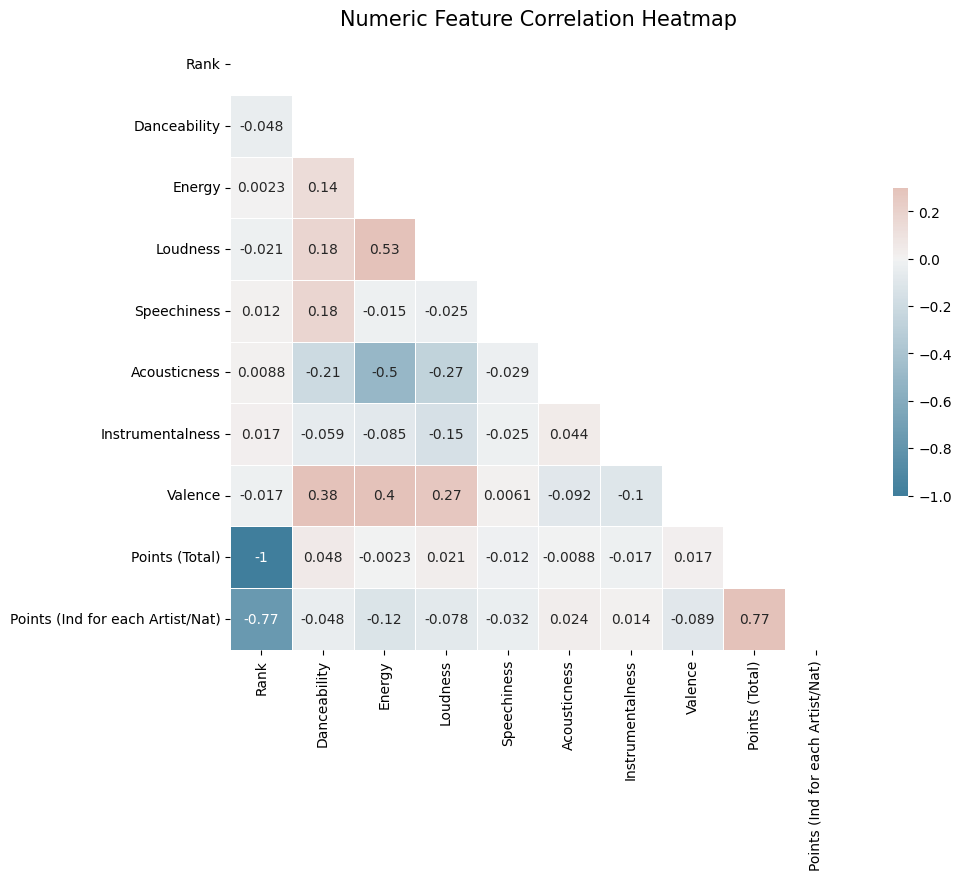

In [6]:
# Compute the correlation matrix
corr_matrix = spotify_song_data_reduced.corr()

# Generate a mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set matplotlib figure
plt.figure(figsize=(12, 8))

# Generate colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Title and display the plot
plt.title("Numeric Feature Correlation Heatmap", fontsize=15)
plt.show()

We can clearly see that there are not any correlation between musical attribution and Point almost
But we can still concentrate on whether exists the correlation between musical attribution and different nationalities

Due to the data of nationalities are too many, so we transfer them to continent, identify the correlaiton of continent and attribution

In [7]:
# Calculating means of the musical features in each continent
musical_features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 
                    'Acousticness', 'Instrumentalness', 'Valence']
mean_values_per_continent = spotify_song_data.groupby('Continent')[musical_features].mean()

# Displaying the means
mean_values_per_continent.sort_values(by='Danceability', ascending=False)

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence
Continent,,,,,,,
Latin-America,0.748943,0.709506,-4337.162528,0.124748,0.238553,0.003229,0.632776
Africa,0.735743,0.677075,-4897.479589,0.092409,0.196211,0.016327,0.541201
Asia,0.707159,0.697001,-4945.405014,0.090986,0.161881,0.001735,0.541093
Anglo-America,0.687851,0.614019,-5796.660216,0.116090,0.228825,0.010283,0.472789
Europe,0.669450,0.666961,-5264.483280,0.085314,0.234237,0.007389,0.518538
Oceania,0.630588,0.668204,-5358.014521,0.090270,0.232568,0.001744,0.476431
Unknown,0.626140,0.740004,-4521.699591,0.053744,0.076103,0.030632,0.468153


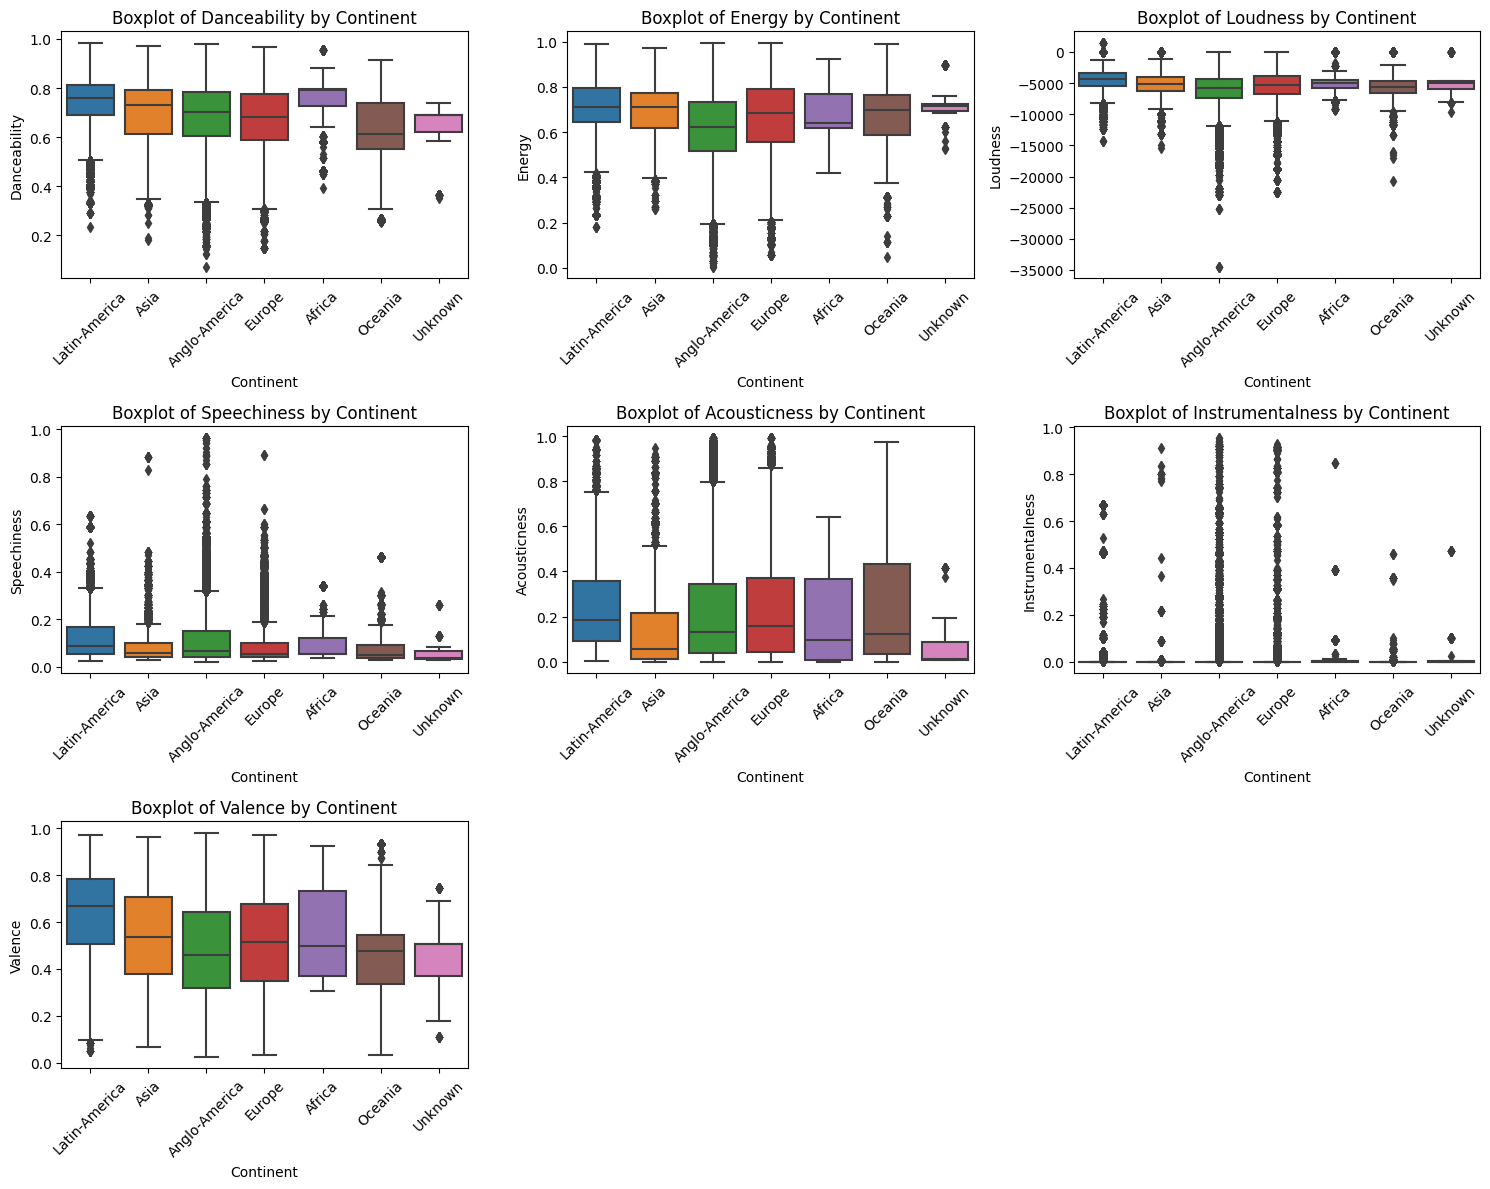

In [8]:
# Set matplotlib figure
plt.figure(figsize=(15, 12))

# Create subplots for each musical feature
for i, feature in enumerate(musical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Continent', y=feature, data=spotify_song_data)
    plt.title(f'Boxplot of {feature} by Continent')
    plt.xticks(rotation=45)
    plt.tight_layout()

# Display the plots
plt.show()

Danceability：Latin-America的歌曲在可舞动性上的中位数最高

Energy：不同大陆在能量特质上的分布差异较大，其中“Unknown”大陆的中位数最高

Loudness：大多数大陆在响度上的分布相近，但“Anglo-America”稍微较低

Speechiness：Latin-America的歌曲在说唱性上的分布最高

Acousticness：Latin-America的歌曲在声学性上的中位数也较高

Instrumentalness：“Unknown”大陆在乐器性上的中位数最高

Valence：Latin-America在正向情感度上的分布也较高

Next, we find out if there are corellation between artist and point

Since the 'Artists' field seems to contain multiple artists in some records, we will use 'Artist (Ind.)' for analysis.

In [9]:
# Calculating the average points for each artist
average_points_per_artist = spotify_song_data.groupby('Artist (Ind.)')['Points (Total)'].mean()

# Converting the series to a dataframe and resetting the index
average_points_df = average_points_per_artist.reset_index()

# Renaming the columns for clarity
average_points_df.rename(columns={'Points (Total)': 'Average Points'}, inplace=True)

# Displaying the first few rows of the dataframe
average_points_df.head()

,Artist (Ind.),Average Points
0,$NOT,51.978495
1,$uicideboy$,68.100000
2,(G)I-DLE,69.765217
3,*NSYNC,75.931034
4,070 Shake,144.101266


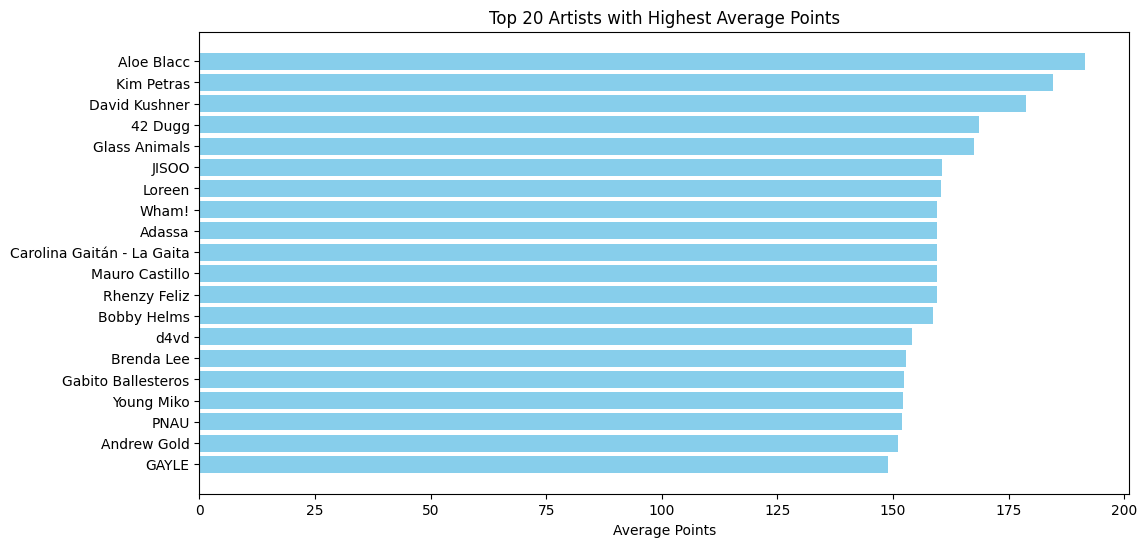

In [10]:
# Selecting the top artists based on average points for visualization
top_artists = average_points_df.nlargest(20, 'Average Points')

# Creating a bar plot
plt.figure(figsize=(12, 6))
plt.barh(top_artists['Artist (Ind.)'], top_artists['Average Points'], color='skyblue')
plt.xlabel('Average Points')
plt.title('Top 20 Artists with Highest Average Points')
plt.gca().invert_yaxis()  # To have the highest on top
plt.show()

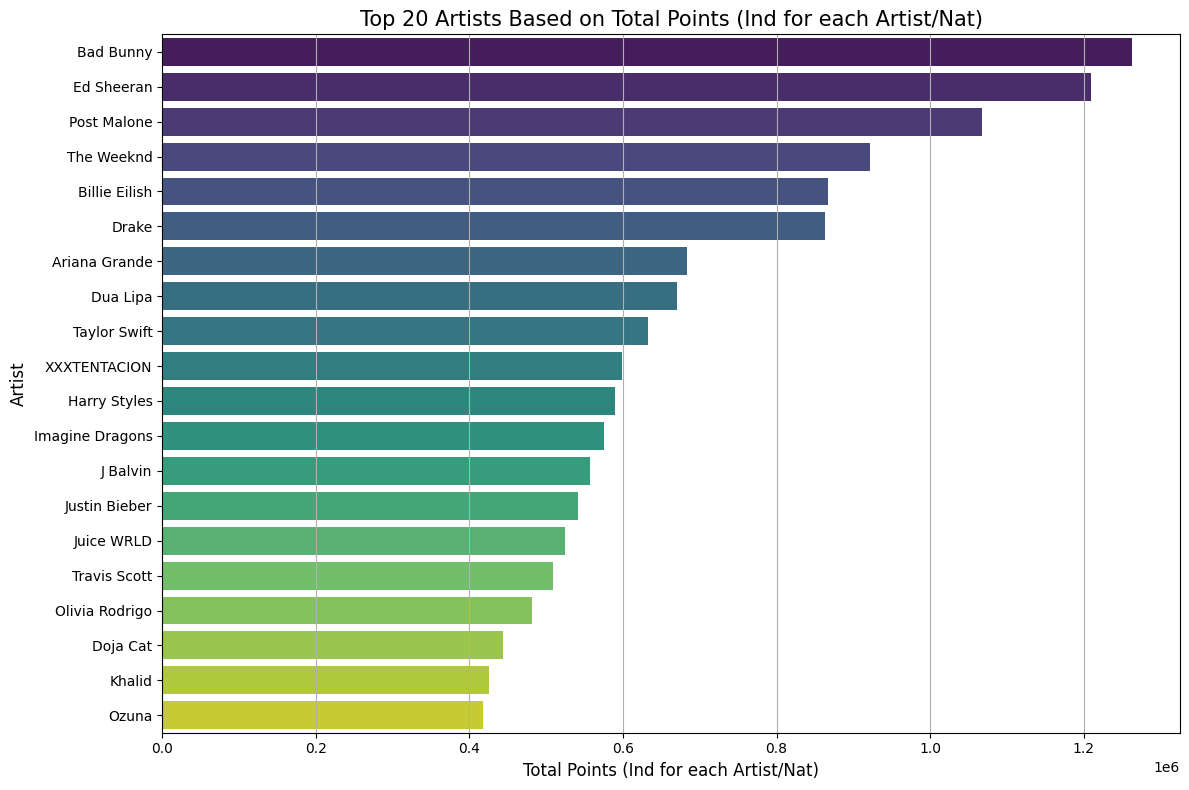

In [11]:
# Grouping by artist and calculating the total points for each artist
artist_total_points = spotify_song_data.groupby('Artist (Ind.)')['Points (Ind for each Artist/Nat)'].sum()

# Sorting the artists by total points and selecting the top 20
top_artists = artist_total_points.sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.xlabel('Total Points (Ind for each Artist/Nat)', fontsize=12)
plt.ylabel('Artist', fontsize=12)
plt.title('Top 20 Artists Based on Total Points (Ind for each Artist/Nat)', fontsize=15)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

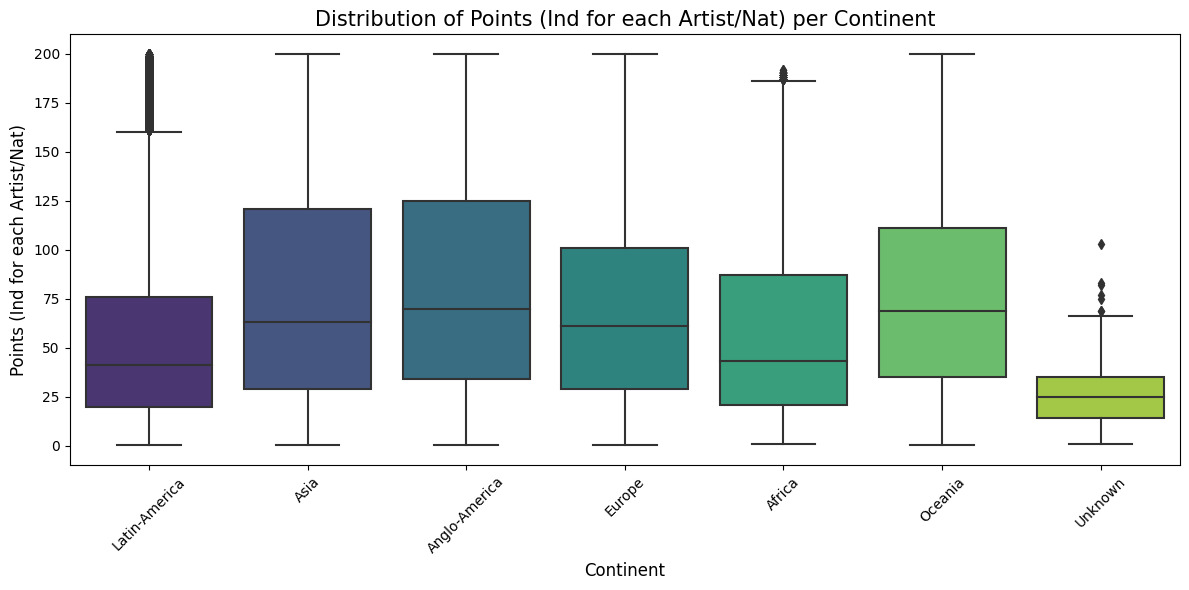

Continent
Anglo-America    81.289828
Oceania          79.639849
Asia             77.480303
Europe           72.581015
Africa           56.795958
Latin-America    53.445319
Unknown          25.442294
Name: Points (Ind for each Artist/Nat), dtype: float64

In [12]:


# Calculating average Points per continent
avg_points_per_continent = spotify_song_data.groupby('Continent')['Points (Ind for each Artist/Nat)'].mean().sort_values(ascending=False)

# Plotting boxplot for Points distribution per continent
plt.figure(figsize=(12, 6))
sns.boxplot(data=spotify_song_data, x='Continent', y='Points (Ind for each Artist/Nat)', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Points (Ind for each Artist/Nat)', fontsize=12)
plt.title('Distribution of Points (Ind for each Artist/Nat) per Continent', fontsize=15)
plt.tight_layout()
plt.show()

# Displaying average Points per continent
avg_points_per_continent

we can see a huge difference, so it shows artist is an important factor for cross-reginal popularity

In [13]:
# ANOVA Test
f_stat, p_value = stats.f_oneway(*(spotify_song_data['Points (Ind for each Artist/Nat)'][spotify_song_data['Continent'] == continent] for continent in spotify_song_data['Continent'].unique()))

(f_stat, p_value)

# Since the p-value is much smaller than the common significance level

# This shows that the continent may indeed be related to the Points of the song

(4974.431855248046, 0.0)

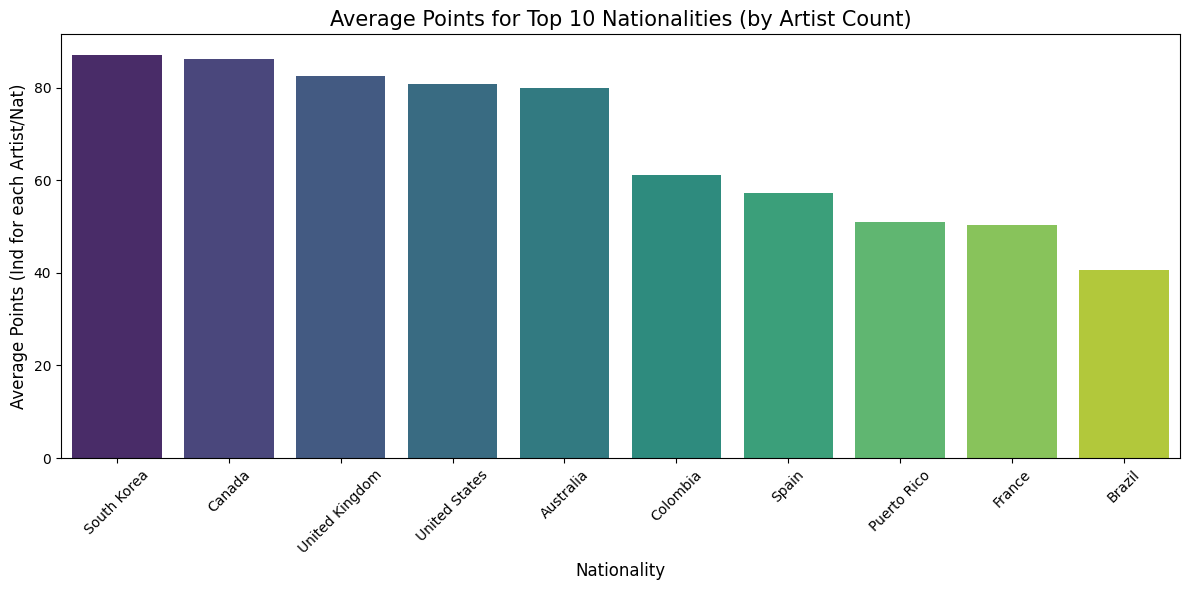

Nationality
South Korea       87.144093
Canada            86.176786
United Kingdom    82.531391
United States     80.877584
Australia         79.998835
Colombia          61.169901
Spain             57.155587
Puerto Rico       50.886091
France            50.361817
Brazil            40.573903
Name: Points (Ind for each Artist/Nat), dtype: float64

In [14]:
# Besides, nationality would like to be a factor
artist_count_per_nationality = spotify_song_data['Nationality'].value_counts()

# Selecting the top 10 nationalities that have the most artists
top_nationalities_by_count = artist_count_per_nationality.head(10).index

# Calculating the average points for these top nationalities
avg_points_top_nationalities = spotify_song_data[spotify_song_data['Nationality'].isin(top_nationalities_by_count)].groupby('Nationality')['Points (Ind for each Artist/Nat)'].mean().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_points_top_nationalities.index, y=avg_points_top_nationalities.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Nationality', fontsize=12)
plt.ylabel('Average Points (Ind for each Artist/Nat)', fontsize=12)
plt.title('Average Points for Top 10 Nationalities (by Artist Count)', fontsize=15)
plt.tight_layout()
plt.show()

# Displaying the data
avg_points_top_nationalities

Can we figure out which artists or genres are going to be popular in 2024 given the historic data from 2017?

###### Data preprogressing

In [15]:
#Create a new column for each artists' average score

# Step 1: Calculate the average points for each artist
artist_avg_points = spotify_song_data.groupby('Artist (Ind.)')['Points (Total)'].mean()

# Step 2: Function that returns the average points of artists
def get_artist_average_points(artists):
    # For multiple artists, we calculate the mean of their average points
    artist_list = artists.split(", ")  # Assuming artists are separated by ", "
    avg_points_list = [artist_avg_points.get(artist, 0) for artist in artist_list]
    return sum(avg_points_list) / len(avg_points_list) if avg_points_list else 0

# Step 3: Apply the function to the 'Artists' column
spotify_song_data['Artist_Average_Points'] = spotify_song_data['Artists'].apply(get_artist_average_points)

# Show the first few rows of the dataframe to verify the new column
spotify_song_data[['Artists', 'Artist_Average_Points']].head()


,Artists,Artist_Average_Points
0,"Eslabon Armado, Peso Pluma",130.833693
1,"Eslabon Armado, Peso Pluma",130.833693
2,Bad Bunny,121.477141
3,"Yng Lvcas, Peso Pluma",132.081395
4,"Yng Lvcas, Peso Pluma",132.081395


In [16]:
spotify_one_hot = pd.get_dummies(spotify_song_data, columns=['Continent'])

# Applying one-hot encoding to the 'Continent' column and adding it to the original dataframe
spotify_song_data = pd.concat([spotify_song_data, pd.get_dummies(spotify_song_data['Continent'], prefix='Continent')], axis=1)

spotify_song_data.head(4)

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,id,Song URL,Artist_Average_Points,Continent_Africa,Continent_Anglo-America,Continent_Asia,Continent_Europe,Continent_Latin-America,Continent_Oceania,Continent_Unknown
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,...,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,130.833693,0,0,0,0,1,0,0
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,...,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,130.833693,0,0,0,0,1,0,0
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,...,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,121.477141,0,0,0,0,1,0,0
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,...,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,132.081395,0,0,0,0,1,0,0


In [17]:
# Step 1: Grouping the data by artist and calculating the total points
artist_total_points = spotify_song_data.groupby('Artist (Ind.)')['Points (Ind for each Artist/Nat)'].sum()

# Step 2: Creating a new column in the original dataframe that maps the total points for each artist
spotify_song_data['Artist_Total_Points'] = spotify_song_data['Artist (Ind.)'].map(artist_total_points)

spotify_song_data[['Artist (Ind.)', 'Artist_Total_Points']].head()

,Artist (Ind.),Artist_Total_Points
0,Eslabon Armado,1.081600e+04
1,Peso Pluma,6.299500e+04
2,Bad Bunny,1.262144e+06
3,Yng Lvcas,1.204600e+04
4,Peso Pluma,6.299500e+04


In [18]:
# Extracting year and month
spotify_song_data['Year'] = pd.to_datetime(spotify_song_data['Date']).dt.year
spotify_song_data['Month'] = pd.to_datetime(spotify_song_data['Date']).dt.month

spotify_song_data[['Date', 'Year', 'Month']].head()

,Date,Year,Month
0,29/05/2023,2023,5
1,29/05/2023,2023,5
2,29/05/2023,2023,5
3,29/05/2023,2023,5
4,29/05/2023,2023,5


###### Model: logistic regression

我们目前处理了三个因素，Artist_Average_Points, Artist_Total_Points, different continent. 
现在我对2017年1月-2017年12月的数据作为训练集进行学习，并根据2023年1月到2023年5月的数据作为对照集测试，
model用逻辑回归，把Point前25%的歌曲表示为流行，预测歌曲是否流行

In [19]:
# Organized Code for the Entire Process

# 1. Data Preprocessing

# Extracting year and month from the 'Date' column
spotify_song_data['Year'] = pd.to_datetime(spotify_song_data['Date']).dt.year
spotify_song_data['Month'] = pd.to_datetime(spotify_song_data['Date']).dt.month

# Defining the target variable based on the top 25% of points
threshold = spotify_song_data['Points (Total)'].quantile(0.75)
spotify_song_data['Popular'] = (spotify_song_data['Points (Total)'] >= threshold).astype(int)

# 2. Feature Selection and Dataset Splitting

# Selecting features and target
continent_features = [col for col in spotify_song_data.columns if col.startswith('Continent_')]
features = ['Artist_Average_Points', 'Artist_Total_Points'] + continent_features
target = 'Popular'

# Splitting the dataset into training and testing sets
train_data = spotify_song_data[(spotify_song_data['Year'] >= 2017)]
#                                & (spotify_song_data['Year'] <= 2022)]
test_data = spotify_song_data[(spotify_song_data['Year'] == 2023)]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Normalizing the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Model Training

# Training the logistic regression model
lr_model = LogisticRegression(random_state=0, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# 4. Model Evaluation

# Evaluating the model on the test set
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep

(0.6060202388464325,
 '              precision    recall  f1-score   support\n\n           0       0.91      0.51      0.66     31266\n           1       0.39      0.86      0.54     11523\n\n    accuracy                           0.61     42789\n   macro avg       0.65      0.69      0.60     42789\nweighted avg       0.77      0.61      0.62     42789\n')

In [20]:
def print_evaluation_report(accuracy, classification_rep):
    """
    Print the evaluation report in a formatted manner.

    Parameters:
    accuracy (float): The accuracy score of the model.
    classification_rep (str): The classification report as a string.
    """
    print(f"{' Model Evaluation Results ':-^60}\n")
    print(f"Overall Accuracy: {accuracy:.2%}\n")
    print("Detailed Classification Report:")
    print(classification_rep)
    print("-"*60)

# 4. Model Evaluation

# Evaluating the model on the test set
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Printing the evaluation report using the new function
print_evaluation_report(accuracy, classification_rep)

----------------- Model Evaluation Results -----------------

Overall Accuracy: 60.60%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.51      0.66     31266
           1       0.39      0.86      0.54     11523

    accuracy                           0.61     42789
   macro avg       0.65      0.69      0.60     42789
weighted avg       0.77      0.61      0.62     42789

------------------------------------------------------------
